# Exploratory Data Analysis for US Air data

In this section we will explore the data from the US domestic air as downloaded from: https://arch.library.northwestern.edu/concern/datasets/pn89d700k.
First we will look at the raw data, then at the to_file.csv created in 0_raw2features_usair.py and the feature file called usair_2004_2021.csv

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

## Explore all US data

In the next section we will evaluate the raw US data. 

In [19]:
path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/data/raw_usair_data'
files = os.listdir(path)
dfs = []

for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)
        
all_us_data = pd.concat(dfs, ignore_index=True)

In [7]:
all_us_data

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,SEATS,PASSENGERS,DISTANCE,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,MONTH,Unnamed: 17
0,0.0,2.0,348.0,326.0,1235.0,CO,Continental Air Lines Inc.,12266,IAH,"Houston, TX",TX,10821,BWI,"Baltimore, MD",MD,2009,7,NaN
1,0.0,1.0,152.0,54.0,1379.0,CO,Continental Air Lines Inc.,12266,IAH,"Houston, TX",TX,12892,LAX,"Los Angeles, CA",CA,2009,7,NaN
2,0.0,2.0,18.0,18.0,65.0,8E,Bering Air Inc.,14805,SHH,"Shishmaref, AK",AK,12822,KTS,"Brevig Mission, AK",AK,2009,8,NaN
3,0.0,2.0,18.0,15.0,65.0,8E,Bering Air Inc.,14805,SHH,"Shishmaref, AK",AK,12822,KTS,"Brevig Mission, AK",AK,2009,8,NaN
4,0.0,1.0,2.0,0.0,51.0,8E,Bering Air Inc.,15709,WAA,"Wales, AK",AK,12822,KTS,"Brevig Mission, AK",AK,2009,8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376427,1370.0,6.0,0.0,0.0,1858.0,KLQ,Kalitta Charters II,13891,ONT,"Ontario, CA",CA,12945,LEX,"Lexington, KY",KY,2015,9,NaN
6376428,1524.0,762.0,6858.0,5297.0,91.0,9K,Cape Air,10154,ACK,"Nantucket, MA",MA,10721,BOS,"Boston, MA",MA,2015,8,NaN
6376429,1526.0,763.0,6867.0,4808.0,91.0,9K,Cape Air,10721,BOS,"Boston, MA",MA,10154,ACK,"Nantucket, MA",MA,2015,8,NaN
6376430,1552.0,776.0,6984.0,4740.0,91.0,9K,Cape Air,10154,ACK,"Nantucket, MA",MA,10721,BOS,"Boston, MA",MA,2015,7,NaN


In [17]:
# Count the number of Nan values
nans = all_us_data.isna().sum()
nans

DEPARTURES_SCHEDULED          0
DEPARTURES_PERFORMED          0
SEATS                         0
PASSENGERS                    0
DISTANCE                      0
UNIQUE_CARRIER             2393
UNIQUE_CARRIER_NAME         187
ORIGIN_AIRPORT_ID             0
ORIGIN                        0
ORIGIN_CITY_NAME              0
ORIGIN_STATE_ABR              0
DEST_AIRPORT_ID               0
DEST                          0
DEST_CITY_NAME                0
DEST_STATE_ABR                0
YEAR                          0
MONTH                         0
Unnamed: 17             6376432
dtype: int64

In [21]:
same = all_us_data[all_us_data['ORIGIN_CITY_NAME']== all_us_data['DEST_CITY_NAME']]
zero = all_us_data[all_us_data['DEPARTURES_PERFORMED'] == 0.0]
print(f"Number of same source and target: {len(same)}")
print(f"Number of weight = 0: {len(zero)}")

Number of same source and target: 31182
Number of weight = 0: 26638


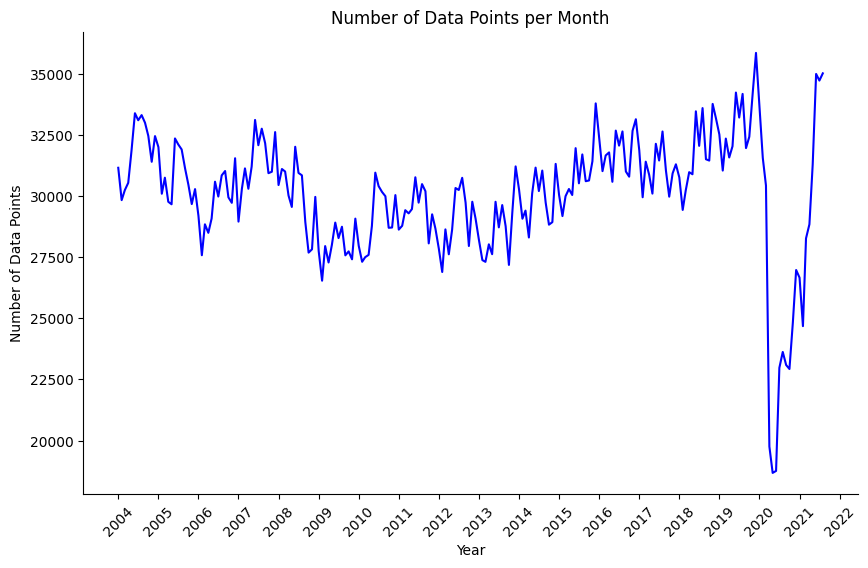

In [34]:
# Create a plot for the number of datapoints
# Convert YEAR and MONTH to datetime and combine into a single column
all_us_data['YearMonth'] = pd.to_datetime(all_us_data[['YEAR', 'MONTH']].assign(day=1))

# Group by YearMonth and count the number of occurrences
monthly_counts = all_us_data.groupby(all_us_data['YearMonth'].dt.to_period('M')).size()

# Convert the index to a datetime format for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_counts.index, monthly_counts.values, color='blue')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month')
plt.xticks(rotation=45)
plt.show()


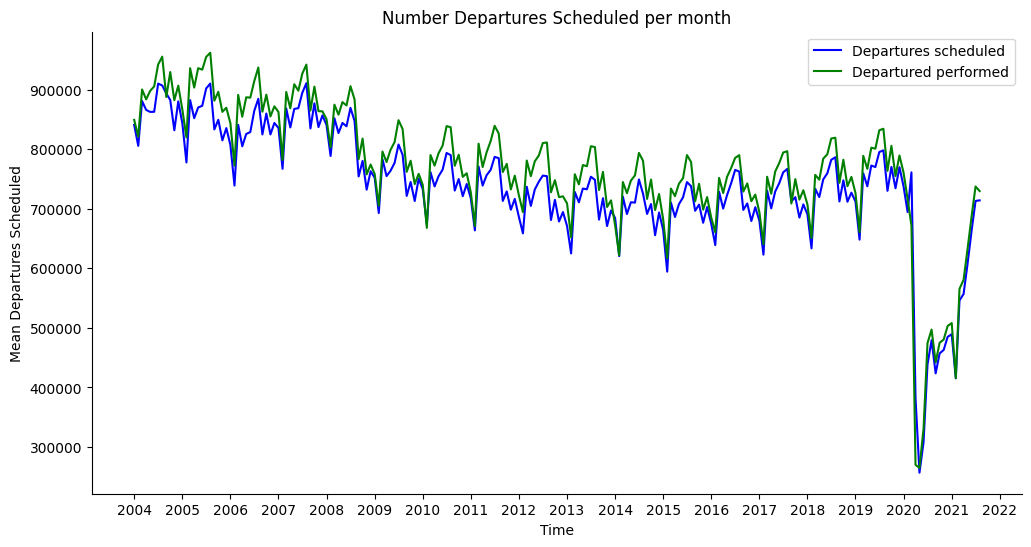

In [33]:
# Plot the number of departures scheduled and number of departures performed
all_us_data['YearMonth'] = pd.to_datetime(all_us_data[['YEAR', 'MONTH']].assign(day=1))

monthly_scheduled = all_us_data.groupby('YearMonth')['DEPARTURES_SCHEDULED'].sum().reset_index()
monthly_departured = all_us_data.groupby('YearMonth')['DEPARTURES_PERFORMED'].sum().reset_index()

# Ensure data is sorted by 'YearMonth'
monthly_scheduled = monthly_scheduled.sort_values(by='YearMonth')
monthly_departured = monthly_departured.sort_values(by='YearMonth')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_scheduled['YearMonth'], monthly_scheduled['DEPARTURES_SCHEDULED'], label='Departures scheduled', color='blue')
ax.plot(monthly_departured['YearMonth'], monthly_departured['DEPARTURES_PERFORMED'], label='Departured performed', color='green')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Mean Departures Scheduled')
ax.set_title('Number Departures Scheduled per month')
ax.legend()
plt.show()

It looks like there are more departures performed than scheduled, which is interesting.

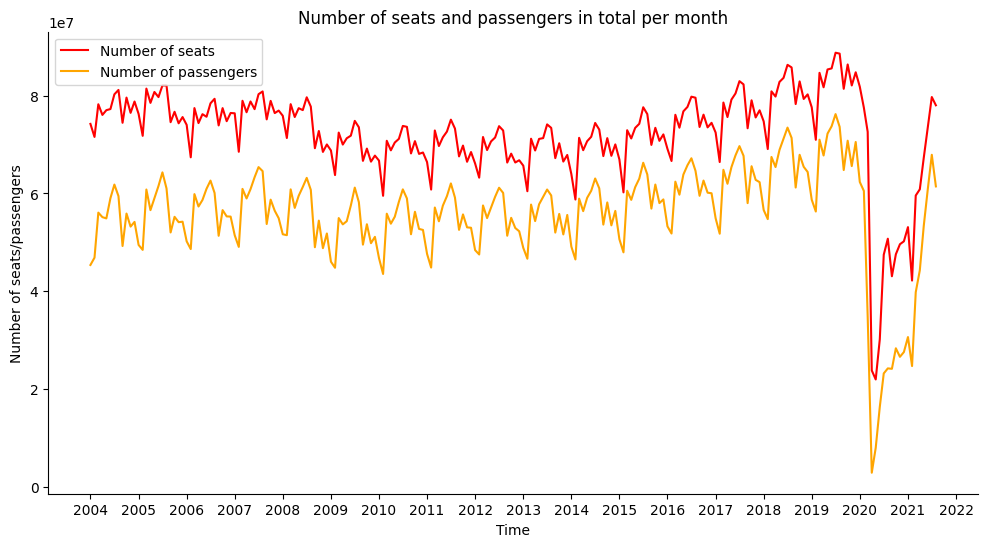

In [35]:
# Plot the number of seats and passengers
all_us_data['YearMonth'] = pd.to_datetime(all_us_data[['YEAR', 'MONTH']].assign(day=1))

seats = all_us_data.groupby('YearMonth')['SEATS'].sum().reset_index()
passengers = all_us_data.groupby('YearMonth')['PASSENGERS'].sum().reset_index()

# Ensure data is sorted by 'YearMonth'
seats = seats.sort_values(by='YearMonth')
passengers = passengers.sort_values(by='YearMonth')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(seats['YearMonth'], seats['SEATS'], label='Number of seats', color='red')
ax.plot(passengers['YearMonth'], passengers['PASSENGERS'], label='Number of passengers', color='orange')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Number of seats/passengers')
ax.set_title('Number of seats and passengers in total per month')
ax.legend()
plt.show()

## Explore to_file

In [42]:
to_file = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/data/to_file.csv', sep=';')
to_file

,YEAR,MONTH,source,target,passengers,weight
0,2004,1,aberdeen_sd,jamestown_nd,45.0,25.0
1,2004,1,aberdeen_sd,minneapolis_mn,2782.0,141.0
2,2004,1,aberdeen_sd,pierre_sd,505.0,52.0
3,2004,1,aberdeen_sd,sioux_falls_sd,0.0,35.0
4,2004,1,aberdeen_sd,watertown_sd,139.0,29.0
...,...,...,...,...,...,...
2112549,2021,8,yakutat_ak,seattle_wa,0.0,7.0
2112550,2021,8,yuma_az,brownsville_tx,0.0,1.0
2112551,2021,8,yuma_az,dallasfort_worth_tx,1611.0,31.0
2112552,2021,8,yuma_az,phoenix_az,6031.0,210.0


In [55]:
same = to_file[to_file['source']== to_file['target']]
zero = to_file[to_file['weight'] == 0.0]
print(f"Number of same source and target: {len(same)}")
print(f"Number of weight = 0: {len(zero)}")

Number of same source and target: 13173
Number of weight = 0: 0


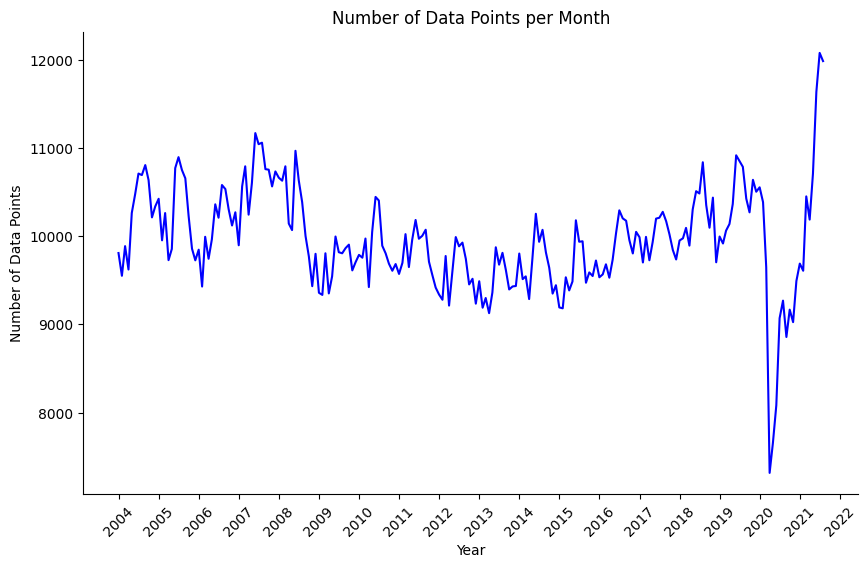

In [43]:
# Create a plot for the number of datapoints
# Convert YEAR and MONTH to datetime and combine into a single column
to_file['YearMonth'] = pd.to_datetime(to_file[['YEAR', 'MONTH']].assign(day=1))

# Group by YearMonth and count the number of occurrences
monthly_counts = to_file.groupby(to_file['YearMonth'].dt.to_period('M')).size()

# Convert the index to a datetime format for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_counts.index, monthly_counts.values, color='blue')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month')
plt.xticks(rotation=45)
plt.show()


## Feature file

In [2]:
features = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/data/features/usair_2004_2021.csv')
features

,Unnamed: 0,Edge,Year,Common Neighbor,Weighted Common Neighbor,Salton,Weighted Salton,Sorensen,Weighted Sorensen,Hub Promoted,...,Curr Weight,Next Weight,Curr FWeight,Next FWeight,Degree Centrality Source,Degree Centrality Target,Closeness Centrality Source,Closeness Centrality Target,Node Strength Source,Node Strength Target
0,0,"('aberdeen_sd', 'jamestown_nd')",2004-01-01,1,26.0,0.258199,0.172219,0.250000,0.139410,0.333333,...,29.0,26.0,0.000068,0.000063,0.005747,0.003448,0.305164,0.304315,296.0,77.0
1,1,"('aberdeen_sd', 'minneapolis_mn')",2004-01-01,4,99.0,0.143223,0.042340,0.049689,0.010551,0.800000,...,137.0,135.0,0.000322,0.000328,0.005747,0.179310,0.305164,0.449678,296.0,18470.0
2,2,"('aberdeen_sd', 'pierre_sd')",2004-01-01,2,31.0,0.338062,0.151742,0.333333,0.141876,0.400000,...,59.0,54.0,0.000139,0.000131,0.005747,0.008046,0.305164,0.310992,296.0,141.0
3,3,"('aberdeen_sd', 'sioux_falls_sd')",2004-01-01,2,166.0,0.190693,0.322516,0.148148,0.278757,0.400000,...,42.0,40.0,0.000099,0.000097,0.005747,0.025287,0.305164,0.329893,296.0,895.0
4,4,"('aberdeen_sd', 'watertown_sd')",2004-01-01,1,53.0,0.316228,0.340191,0.285714,0.280423,0.500000,...,29.0,29.0,0.000068,0.000070,0.005747,0.002299,0.305164,0.304194,296.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222082,1222082,"('uganik_ak', 'west_point_ak')",2021-07-01,2,2.0,0.500000,0.301511,0.500000,0.266667,0.500000,...,1.0,2.0,0.000003,0.000005,0.001947,0.001947,0.098506,0.124478,4.0,11.0
1222083,1222083,"('la_grande_or', 'pendleton_or')",2021-07-01,1,28.0,0.408248,0.429500,0.400000,0.352201,0.500000,...,6.0,6.0,0.000016,0.000016,0.000974,0.001461,0.128315,0.143072,34.0,125.0
1222084,1222084,"('lorainelyria_oh', 'wilmington_de')",2021-07-01,1,1.0,0.408248,0.188982,0.400000,0.125000,0.500000,...,1.0,0.0,0.000003,0.000000,0.000974,0.001461,0.126147,0.137092,2.0,14.0
1222085,1222085,"('modesto_ca', 'salinasmonterey_ca')",2021-07-01,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.000003,0.000000,0.001461,0.000974,0.147057,0.136875,3.0,2.0


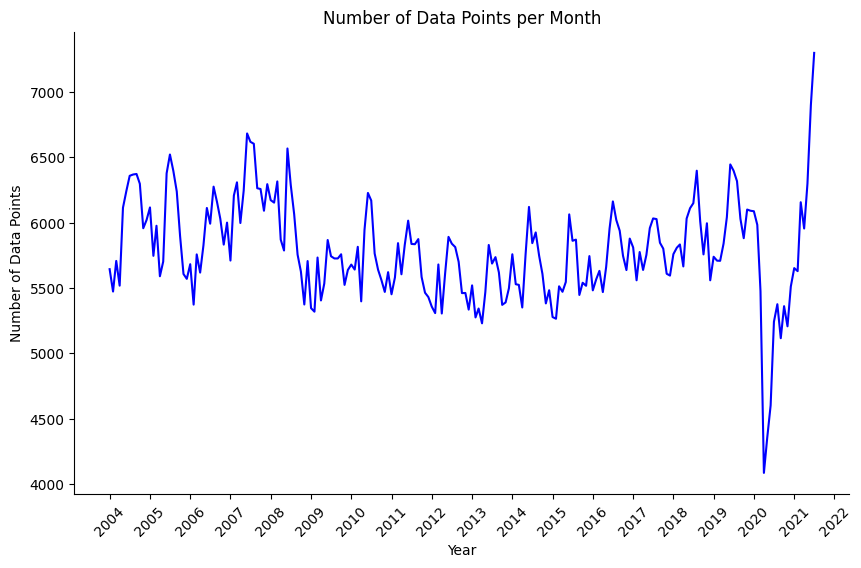

In [3]:
# Create a plot for the number of datapoints
# Convert YEAR and MONTH to datetime and combine into a single column
features['Year'] = pd.to_datetime(features['Year'])

# Group by YearMonth and count the number of occurrences
monthly_counts = features.groupby(features['Year'].dt.to_period('M')).size()

# Convert the index to a datetime format for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_counts.index, monthly_counts.values, color='blue')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month')
plt.xticks(rotation=45)
plt.show()

As you can see there are way less datapoints in the feature_file compared to the to_file. The reason for this is, is that in the feature_file the flights are merged into one connection, while in the to_file the back-and-forth flights are in there are well (e.g., new-york - boston and boston - new-york).

Let's now discover the importance of the features.

In [4]:
true_values = features[features['Removed'] == True]
false_values = features[features['Removed'] == False]

print(f"Number of removed edges: {len(true_values)}")
print(f"Number of not removed edges: {len(false_values)}")

Number of removed edges: 399194
Number of not removed edges: 822893


The dataset is balanced, which is nice.

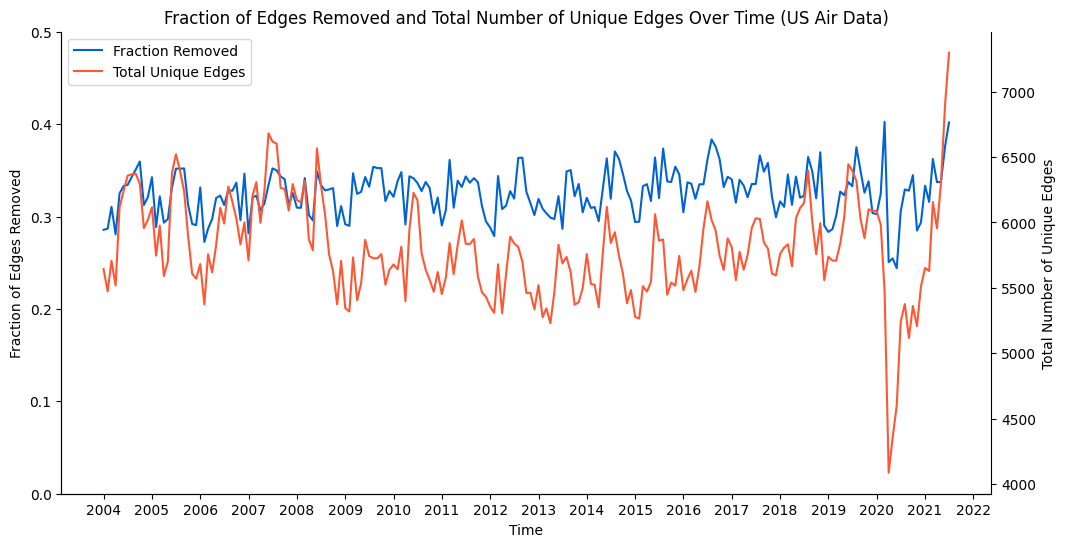

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'Year' column is in datetime format if it's not already
features['Year'] = pd.to_datetime(features['Year'])

# Group by the current month and calculate the fraction of edges removed in the next month
monthly_removed_fraction = features.groupby('Year')['Removed'].mean().reset_index()

# Calculate the total number of edges per month
monthly_total_edges = features.groupby('Year').size().reset_index(name='Total Edges')

# Merge the two dataframes on 'Year' to ensure they align correctly
monthly_data = pd.merge(monthly_removed_fraction, monthly_total_edges, on='Year')

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the fraction of edges removed
ax.plot(monthly_data['Year'], monthly_data['Removed'], label='Fraction Removed', color='#0063D3')

# Plot the total number of edges on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(monthly_data['Year'], monthly_data['Total Edges'], label='Total Unique Edges', color='#FF5733')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks_position('right')

# Set y-axis limits for the fraction removed
ax.set_ylim(0, 0.5)

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Fraction of Edges Removed')
ax2.set_ylabel('Total Number of Unique Edges')
ax.set_title('Fraction of Edges Removed and Total Number of Unique Edges Over Time (US Air Data)')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

In [89]:
# Define feature columns (from 'Common Neighbor' to 'Weighted Jaccard')
feature_cols = [
    'Common Neighbor', 'Weighted Common Neighbor', 'Salton', 'Weighted Salton',
    'Sorensen', 'Weighted Sorensen', 'Hub Promoted', 'Weighted Hub Promoted',
    'Hub Depressed', 'Weighted Hub Depressed', 'Leicht Holme Newman', 
    'Weighted Leicht Holme Newman', 'Preferential Attachment', 
    'Weighted Preferential Attachment', 'Local Path', 'L3 Path', 
    'Weighted Local Path', 'Resource Allocation', 'Weighted Resource Allocation', 
    'Adamic Adar', 'Weighted Adamic Adar', 'Jaccard', 'Weighted Jaccard', 
    'Gravity'
]

# Prepare feature matrix X and target vector y
X = features[feature_cols]
y = features['Removed'].astype(int)  # Ensure target is in integer format

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV with the parameter grid
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_grid, n_iter=50, scoring='accuracy',
    n_jobs=-1, cv=3, verbose=2, random_state=42
)

# Fit the model with the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy with Best Parameters: {accuracy:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time= 1.4min
[CV] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time= 1.4min
[CV] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time= 1.5min
[CV] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 1.7min
[CV] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 1.7min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=400, subsample=0.6; total time= 3.4min
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=400, subsample=0.6; total time= 3.4min
[CV] END colsample_bytree=0.7, gamma=0.4, learning_

Without hyperparameter tuning, accuracy of 0.835 already. Let's look at the feature importances.

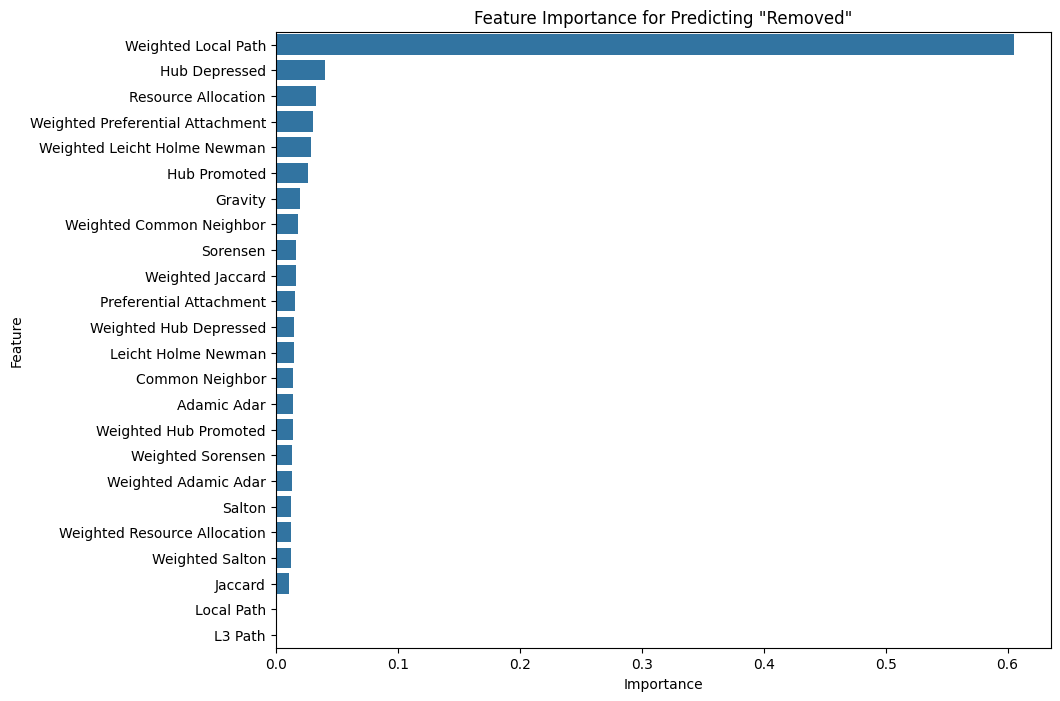

In [90]:
# Get feature importance scores
feature_importances = best_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting "Removed"')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Weighted Local Path seems to be important .

## Long term prediction

In [93]:
import pickle

# Path to the .pkl file
pkl_file = '/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/results/2004-02-01pred_36.pkl'
with open (pkl_file, 'rb') as file:
    df = pickle.load(file)
    
df

{datetime.date(2004, 2, 1): ([0.5368705035971223,
   0.3403185247275775,
   0.3132530120481928,
   0.3519245875883739,
   0.3228915662650602,
   0.3487841945288754,
   0.3614369501466276,
   0.3656357388316151,
   0.41915760869565216,
   0.41043478260869565,
   0.4257167680278019,
   0.41085840058694056,
   0.4229957805907173,
   0.4216300940438871,
   0.38598326359832635,
   0.4236686390532544,
   0.3968379446640316,
   0.3953823953823954,
   0.4018169112508735,
   0.3870743571924948,
   0.41706539074960125,
   0.42168674698795183,
   0.4144050104384134,
   0.45495093666369313,
   0.3939828080229226,
   0.41953488372093023,
   0.40408163265306124,
   0.40766902119071646,
   0.40084745762711865,
   0.38188976377952755,
   0.41711229946524064,
   0.4088145896656535,
   0.4333087693441415,
   0.4079207920792079,
   0.41467065868263475,
   0.398876404494382],
  [0.6160071942446043,
   0.5725871857258719,
   0.547945205479452,
   0.6116165150454863,
   0.569593147751606,
   0.5958023019634

In [94]:
# Path to the .pkl file
pkl_file = '/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/results/2004-02-01pred_36_null.pkl'
with open (pkl_file, 'rb') as file:
    df = pickle.load(file)
    
df

{datetime.date(2004, 2, 1): ([0.21402877697841727,
   0.20070733863837312,
   0.18280871670702178,
   0.1930567315834039,
   0.1527655838454785,
   0.18221070811744386,
   0.17842660178426603,
   0.19802731411229135,
   0.21470588235294116,
   0.19904306220095694,
   0.20119521912350596,
   0.16449511400651465,
   0.15384615384615385,
   0.18557607739665788,
   0.13533834586466165,
   0.1362940275650842,
   0.19496268656716417,
   0.17661900756938603,
   0.17993630573248406,
   0.1657754010695187,
   0.17907801418439717,
   0.14348302300109528,
   0.15535248041775457,
   0.1464393179538616,
   0.12195121951219512,
   0.1695095948827292,
   0.14901960784313725,
   0.15586034912718205,
   0.15115115115115116,
   0.16189290161892902,
   0.18021201413427562,
   0.18237885462555067,
   0.17428087986463622,
   0.1374133949191686,
   0.1901840490797546,
   0.14136904761904762],
  [])}

'/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/results/2004-02-01pred_36.pkl'